In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import src.basic_function_cap as bfc
import src.piano_key_notes as pkn
import src.hands as h
import ipywidgets as widgets
from ipywidgets import interact

# Hand region

In [2]:
cap = cv2.VideoCapture('mp4/scarborough_fair.mp4')

def show_frame(frame_number, shift, threshold):
    _, mask = bfc.get_frame(cap, 814)
    _, frame = bfc.get_frame(cap, frame_number)
    mask = bfc.crop_frame(mask, 375, 0, 540-375, mask.shape[1], show=False)
    frame = bfc.crop_frame(frame, 375, 0, 540-375, frame.shape[1], show=False)
    plt.figure(figsize=(16,16))
    plt.imshow(frame)
    plt.show()
    plt.figure(figsize=(16,16))
    plt.imshow(frame - mask + shift)
    plt.show()

interact(show_frame,
        frame_number=widgets.IntSlider(min=0, max=814, step=1, value=10),
        shift=widgets.IntSlider(min=0, max=30, step=1, value=10),
        threshold=widgets.IntSlider(min=0, max=100, step=1, value=30))

interactive(children=(IntSlider(value=10, description='frame_number', max=814), IntSlider(value=10, descriptio…

<function __main__.show_frame(frame_number, shift, threshold)>

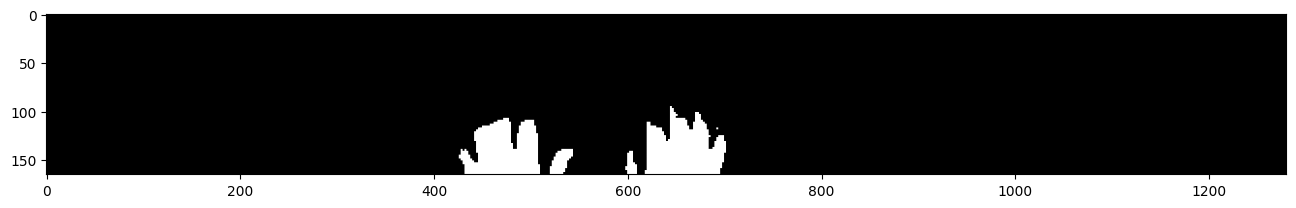

In [3]:
_, frame = bfc.get_frame(cap, 10)
frame = bfc.crop_frame(frame, 375, 0, 540-375, frame.shape[1], show=False)
frame_hands_isolated = h.get_hand_region(frame, 30, True)

# Show notes

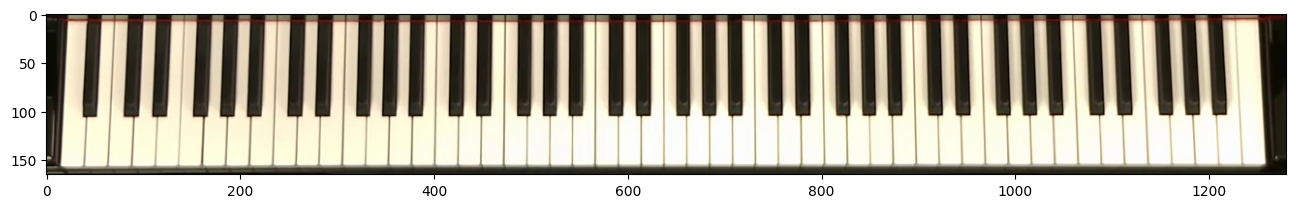

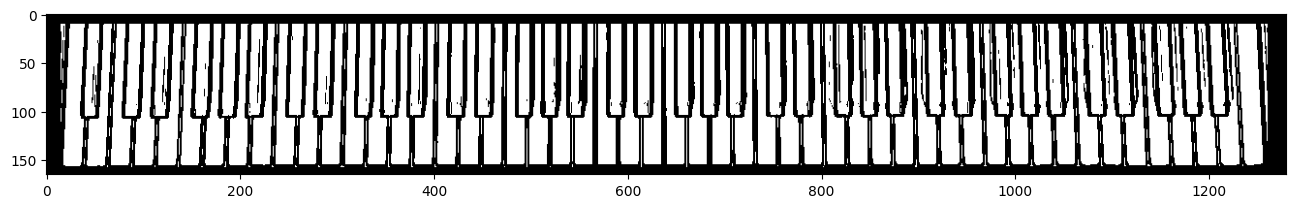

Number of connected components: 88


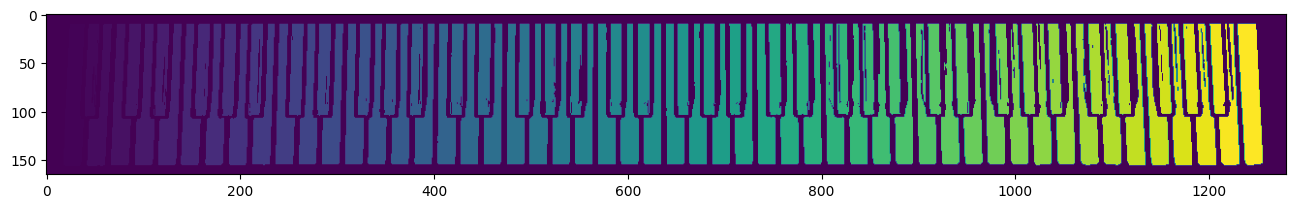

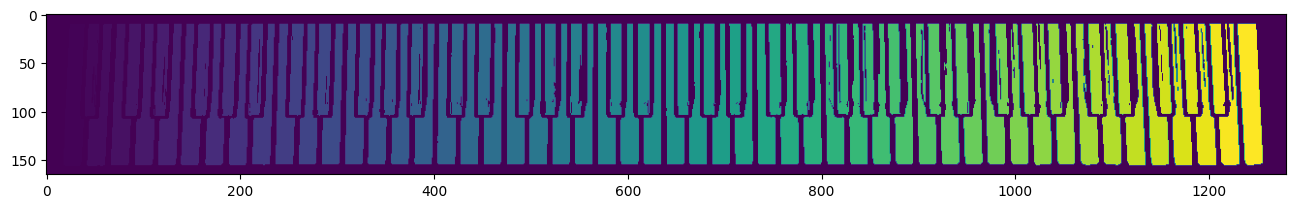

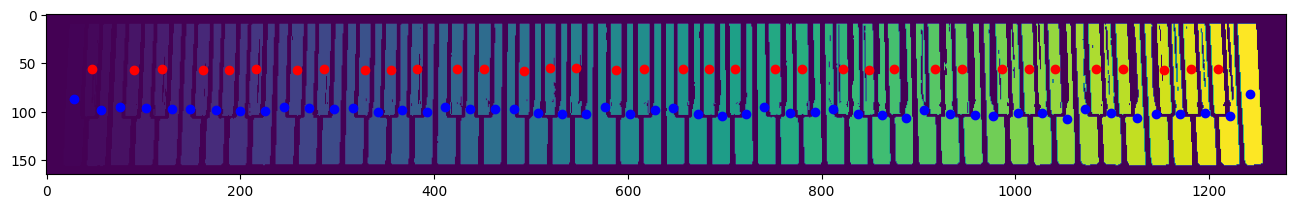

  0%|          | 0/36 [00:00<?, ?it/s]

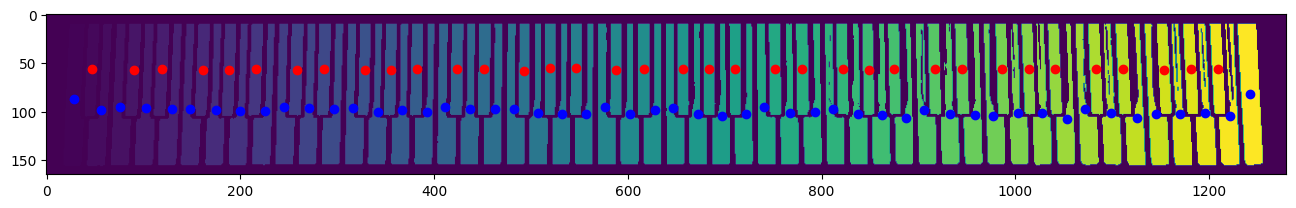

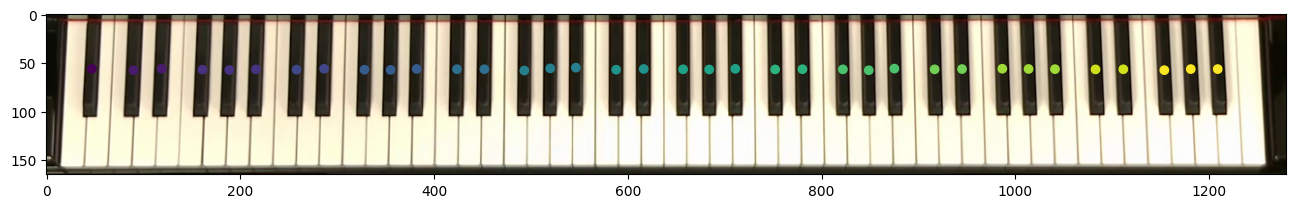

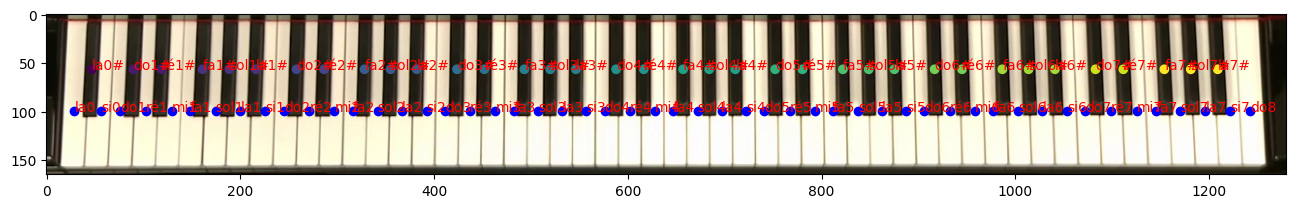

In [4]:
cap = cv2.VideoCapture('mp4/scarborough_fair.mp4')
image = bfc.get_frame(cap, 814)[1]
image = bfc.crop_frame(image, 375, 0, 540-375, image.shape[1], show=True)
pipe = pkn.pipeline(image, with_hull=True, threshold = 4000, kx=15, crop=[10,7,15,19], min_area=300, max_width=200, show=True)
labels, black_keys, white_keys, n_labels, stats, centroids, group, notes, sobel = pipe

In [5]:
g = [0,255,0]
b = [0,0,255]
r = [255,0,0]

def show_frame(frame_number, key):
    _, image = bfc.get_frame(cap, frame_number)
    image = bfc.crop_frame(image, 375, 0, 540-375, image.shape[1], show=False)
    _ = pkn.highlight_keys(image=image, labels=labels, keys = key, color = [g,g,r], show=True)

interact(show_frame,
        frame_number=widgets.IntSlider(min=0, max=814, step=1, value=10),
        key=widgets.IntSlider(min=0, max=88, step=1, value=10))

interactive(children=(IntSlider(value=10, description='frame_number', max=814), IntSlider(value=10, descriptio…

<function __main__.show_frame(frame_number, key)>

# Check difference above hands

In [6]:
_, frame = bfc.get_frame(cap, 10)
frame = bfc.crop_frame(frame, 375, 0, 540-375, frame.shape[1], show=False)
frame_hands_isolated = h.get_hand_region(frame, 30, False)

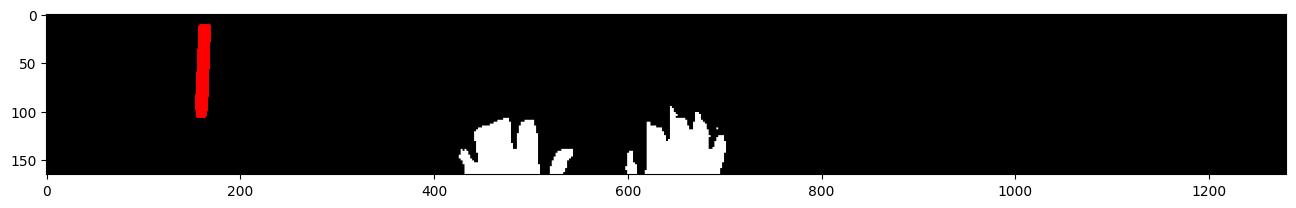

In [7]:
frame_hands_isolated = cv2.cvtColor(frame_hands_isolated.astype(np.uint8), cv2.COLOR_BGR2RGB)
list_testing = h.get_list_pixels(frame_hands_isolated, 10, labels, above=0)

plt.figure(figsize=(16,6))
plt.imshow(frame_hands_isolated)
plt.scatter(list_testing[1], list_testing[0], s=1, c='r')
plt.show()

# Pipeline final

In [8]:
cap = cv2.VideoCapture('mp4/scarborough_fair.mp4')
_, mask = bfc.get_frame(cap, 814)
mask = bfc.crop_frame(mask, 375, 0, 540-375, mask.shape[1], show=False)
n = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
pipe = pkn.pipeline(mask, with_hull=True, threshold = 4000, kx=15, crop=[10,7,15,19], min_area=300, max_width=200, show=False)
labels, black_keys, white_keys, n_labels, stats, centroids, group, notes, sobel = pipe

Number of connected components: 88


  0%|          | 0/36 [00:00<?, ?it/s]

In [9]:
def show_frame_from_video_and_key_pressed(frame_number, threshold_hand=30, above=10, threshold_confidence=150):
    _, frame = bfc.get_frame(cap, frame_number)
    frame = bfc.crop_frame(frame, 375, 0, 540-375, frame.shape[1], show=False)
    if frame is not None:
        plt.figure(figsize=(20,6))
        plt.imshow(h.pipeline_key_pressed(frame, mask, labels, centroids, threshold_hand, above, threshold_confidence, show=False))
        plt.show()
    else:
        print('Frame not found')

interact(show_frame_from_video_and_key_pressed, frame_number=(0, n-1, 1),
            threshold_hand=(0, 255, 1), above=(0, 100, 1), threshold_confidence=(0, 255, 1))

interactive(children=(IntSlider(value=457, description='frame_number', max=915), IntSlider(value=30, descripti…

<function __main__.show_frame_from_video_and_key_pressed(frame_number, threshold_hand=30, above=10, threshold_confidence=150)>

In [11]:
#fourcc = cv2.VideoWriter_fourcc(*'h264')
#out = cv2.VideoWriter('mp4/keyboard_confidence.mp4', fourcc, cap.get(cv2.CAP_PROP_FPS),
#            (frame.shape[1],540-375))

from tqdm import tqdm
cap = cv2.VideoCapture('mp4/scarborough_fair.mp4')

for i in tqdm(range(0, n)):
    ret, frame = cap.read()
    if ret:
        frame = bfc.crop_frame(frame, 375, 0, 540-375, frame.shape[1], show=False)
        frame = cv2.cvtColor(frame.astype(np.uint8), cv2.COLOR_BGR2RGB)
        image = h.pipeline_key_pressed(frame, mask, labels, centroids, threshold_hand=30, above=10, threshold_confidence=130, show=False)
        image = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_BGR2RGB)
#        out.write(image)
    else:
        break

#out.release()

 89%|███████████████████████████████████████████████████████████████████████▎        | 816/916 [00:22<00:02, 36.36it/s]


In [12]:
# attach audio from mp4/scarborough_fair.mp4 to mp4/keyboard_confidence.mp4

#!ffmpeg -i mp4/keyboard_confidence.mp4 -i mp4/scarborough_fair.mp4 -c copy -map 0:v:0 -map 1:a:0 mp4/keyboard_confidence_with_audio.mp4